# Computer vision for understanding the displacement/stimulus relationship of BVER units using an external camera 
Lydia Calderon-Aceituno | Summer 2021

The program is based on a Adrian Rosebrock project avaliable [here](https://www.pyimagesearch.com/2015/09/21/opencv-track-object-movement/#pyis-cta-modal). All software in object_movement.py was developed by Adrian Rosebrock, PhD.

# Required packages

In [ ]:
# import all required packages
from imutils.video import VideoStream
from matplotlib import pyplot as plt
from collections import deque
import numpy as np
import argparse
import imutils
import cv2
import shutil
from imutils import paths
import os
import moviepy.editor # to find the duration of the video
import datetime
import csv # for exporting (x,y,t) coordinates
from csv import DictWriter # for writing to CSV file 
# for 3D graph 
import plotly.express as px
import pandas as pd

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2555904/45929032 bytes (5.6%)5341184/45929032 bytes (11.6%)8110080/45929032 bytes (17.7%)10846208/45929032 bytes (23.6%)13451264/45929032 bytes (29.3%)16138240/45929032 bytes (35.1%)18776064/45929032 bytes (40.9%)21372928/45929032 bytes (46.5%)24174592/45929032 bytes (52.6%)26763264/45929032 bytes (58.3%)29384704/45929032 bytes (64.0%)31801344/45929032 bytes (69.2%)

In [ ]:
# common image display function 
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

# Setting up the enviornment 
This project requires files located in Google Drive. These files are imported and copied into a local runtime folder.

In [ ]:
# add ability to import from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# make project file 
!mkdir track-marker-movement 

In [ ]:
# copy the python file from google drive to the runtime directory 
src = '/content/drive/MyDrive/BVER Python Projects/Color Tracking/object_movement.py'
dst =  '/content/track-marker-movement'
shutil.copy(src, dst)

'/content/track-marker-movement/object_movement.py'

In [ ]:
# copy the video files from google drive to the runtime directory 

# create local folder 
!mkdir track-marker-movement/videos

In [ ]:
# run through all videos in the google drive folder 
for videoPath in os.listdir('/content/drive/MyDrive/BVER Python Projects/Color Tracking/video_data/'):
    if videoPath.endswith("mp4"): # check if the video path is the correct format 
        print("Path identified: ", videoPath) # for verification of the path 
        src = '/content/drive/MyDrive/BVER Python Projects/Color Tracking/video_data/' + videoPath # construct source path 
        dst =  '/content/track-marker-movement/videos' # define destination 
        shutil.copy(src, dst) # copy the file

Path identified:  object_tracking_example.mp4
Path identified:  apple.mp4


## Opening the video file

In [ ]:
# define arguments and values 
args = {
	"video": "track-marker-movement/videos/apple.mp4", # the video to be analyzed 
	"buffer": 32,
	"output" : "output.avi"
}

In [ ]:
# initialize the list of tracked points, the frame counter,
# and the coordinate deltas
pts = deque(maxlen=args["buffer"])
counter = 0
(dX, dY) = (0, 0)
direction = ""

# grab a reference to the video file and initialize pointer to output
# video file
print("[INFO] opening video file...")
vs = cv2.VideoCapture(args["video"])
writer = None

[INFO] opening video file...


# FPS calculations 

The duation of the video is calculated as $\mathrm{duration} = \frac{\mathrm{frames}}{\mathrm{fps}}$. Using the FPS rate, the time consumed by each frame is calculated as $\mathrm{time\_for\_each\_frame} = 1\ \mathrm{frame} * \frac{1\ \mathrm{sec}}{\mathrm{fps}}$.


In [ ]:
fps = vs.get(cv2.CAP_PROP_FPS)
print("FPS: ", fps)
frames = vs.get(cv2.CAP_PROP_FRAME_COUNT)
print("Frames: ", frames)
print("The duration of the video is: ", frames/fps) 
print("time_for_each_frame = ", 1/fps)

FPS:  30.000824764941992
Frames:  582.0
The duration of the video is:  19.399466666666665
time_for_each_frame =  0.03333241695303551


We must also create a file to hold the (x,y,t) coordinates of the marker.

In [ ]:
with open('/content/track-marker-movement/movement_coordinates.csv', mode='w') as csv_file:
    fieldnames = ['x (pix)', 'y (pix)', 't (seconds)']
    movemnt_writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    movemnt_writer.writeheader()

# Color calculations
The program works by collecting each frame of a video individually, identifying the marker, and calculating the displacement in pixels of the marker from its previous position. In order to get an idea of the color parameters of our marker, the RGB values are translated into HSV color space (in which the masking will be done). The upper and lower thresholds for the HSV color space are then defined, an an example frame and mask are displayed.

In [ ]:
# we want to find color boundries in the HSV color space
# if our tracker is red, we must first define red in RGB
rgb_red = np.uint8([[[255, 0, 0]]])  # Define rgb red 
hsv_red = cv2.cvtColor(rgb_red, cv2.COLOR_RGB2HSV)[0, 0, :] # Convert to HSV red 
print("HSV red:", hsv_red)

HSV red: [  0 255 255]


In [ ]:
# define the lower and upper boundaries of the colored 
# marker in the HSV color space
# greenLower = (29, 86, 6)
# greenUpper = (64, 255, 255)
lower_th = (0, 130, 130)
upper_th = (5, 255, 255)

A test frame is collected, masked, and the marker identified.

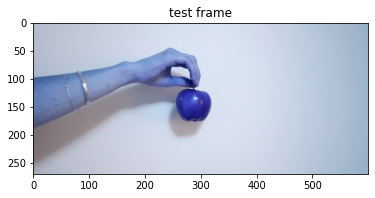

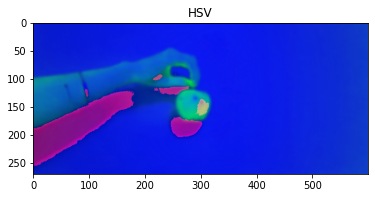

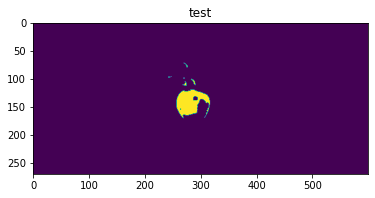

In [ ]:
test_frame = vs.read()[1]
test_frame = imutils.resize(test_frame, width=600)
plt_imshow("test frame", test_frame)
blur = cv2.GaussianBlur(test_frame, (11, 11), 0)
HSV = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)
plt_imshow("HSV", HSV)

mask = cv2.inRange(HSV, lower_th, upper_th)
plt_imshow("test", mask)
mask = cv2.erode(mask, None, iterations=2)
mask = cv2.dilate(mask, None, iterations=2)


# Video Analysis
Time and frame tracking variables are initialized. Within a while loop, each frame is grabbed and the time and disance deltas are calculated. This information, as well as the general compass heading of the marker) is displayed on each frame. The frames are then spiced together to form a new video containing movement analysis data. This loop continues until the end of the video. 

In [ ]:
timestamp = 0 # time stamp for storage in CSV file and priting on frame 
frames = 0 # counting integer to count the number of frames to verify the frame count 

In [ ]:
# keep looping
while True:
  # grab the current frame
  frame = vs.read()[1]

  # if we are viewing a video and we did not grab a frame,
  # then we have reached the end of the video
  if frame is None:
    break

  frames = frames + 1 # increment the number of frames 
  if frames > 1: # if it is the first itiration, do not increment the timestamp 
    timestamp = timestamp + 1/fps; # increment the timestamp for each frame

  # resize the frame, blur it, and convert it to the HSV
  # color space
  frame = imutils.resize(frame, width=600)
  blurred = cv2.GaussianBlur(frame, (11, 11), 0)
  hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

  # construct a mask for the selected color, then perform
  # a series of dilations and erosions to remove any small
  # blobs left in the mask
  mask = cv2.inRange(hsv, lower_th, upper_th)
  mask = cv2.erode(mask, None, iterations=2)
  mask = cv2.dilate(mask, None, iterations=2)

  # find contours in the mask and initialize the current
  # (x, y) center of the ball
  cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  center = None

	# only proceed if at least one contour was found
  if len(cnts) > 0:
    # find the largest contour in the mask, then use
    # it to compute the minimum enclosing circle and
    # centroid
    c = max(cnts, key=cv2.contourArea)
    ((x, y), radius) = cv2.minEnclosingCircle(c)
    M = cv2.moments(c)
    # identify centroid 
    center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

    # only proceed if the radius meets a minimum size
    if radius > 10:
      # draw the circle and centroid on the frame,
      # then update the list of tracked points
      cv2.circle(frame, (int(x), int(y)), int(radius),
        (0, 0, 255), 2)
      cv2.circle(frame, center, 5, (0, 255, 255), -1)
      pts.appendleft(center)

  # loop over the set of tracked points
  for i in np.arange(1, len(pts)):
    # if either of the tracked points are None, ignore
    # them
    if pts[i - 1] is None or pts[i] is None:
      continue

    # check to see if enough points have been accumulated in
    # the buffer
    if counter >= 10 and i == 1 and pts[-10] is not None:
      # compute the difference between the x and y
      # coordinates and re-initialize the direction
      # text variables
      dX = pts[-10][0] - pts[i][0]
      dY = pts[-10][1] - pts[i][1]
      (dirX, dirY) = ("", "")

      # ensure there is significant movement in the
      # x-direction
      if np.abs(dX) > 20:
        dirX = "East" if np.sign(dX) == 1 else "West"

      # ensure there is significant movement in the
      # y-direction
      if np.abs(dY) > 20:
        dirY = "North" if np.sign(dY) == 1 else "South"

      # handle when both directions are non-empty
      if dirX != "" and dirY != "":
        direction = "{}-{}".format(dirY, dirX)

      # otherwise, only one direction is non-empty
      else:
        direction = dirX if dirX != "" else dirY

    # otherwise, compute the thickness of the line and
    # draw the connecting lines
    thickness = int(np.sqrt(args["buffer"] / float(i + 1)) * 2.5)
    cv2.line(frame, pts[i - 1], pts[i], (0, 255, 255), thickness)

  # show the movement deltas, the direction of movement, and the time stamp on
  # the frame
  cv2.putText(frame, direction, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
    0.65, (0, 0, 255), 1)
  cv2.putText(frame, "dx: {}, dy: {}".format(dX, dY),
    (10, frame.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX,
    0.35, (0, 0, 255), 1)
  cv2.putText(frame, str(timestamp) + " s", (300, 30), cv2.FONT_HERSHEY_SIMPLEX,
    0.65, (0, 0, 255), 1)
  
  # export the movement deltas, the direction of movement, and the time stamp to the CSV file 
  dict={'x (pix)': dX,'y (pix)': dY, 't (seconds)': timestamp} # load coordinates into dictionary 
  with open('/content/track-marker-movement/movement_coordinates.csv', 'a') as f_object:
      
    # Pass the file object and a list 
    # of column names to DictWriter()
    dictwriter_object = DictWriter(f_object, fieldnames=fieldnames)
  
    # Pass the dictionary as an argument to the Writerow()
    dictwriter_object.writerow(dict)
  
    #Close the file object
    f_object.close()

  # if the video writer is None *AND* we are supposed to write
  # the output video to disk initialize the writer
  if writer is None and args["output"] is not None:
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    writer = cv2.VideoWriter(args["output"], fourcc, 20,
      (frame.shape[1], frame.shape[0]), True)
  
  # if the writer is not None, write the frame with recognized
  # marker to disk
  if writer is not None:
    writer.write(frame)
  
  # increment the frame counter
  counter += 1

# do a bit of cleanup
vs.release()

# check to see if the video writer point needs to be released
if writer is not None:
	writer.release()

In [ ]:
!ffmpeg -i output.avi output.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

# Output video display

In [ ]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open("output.mp4", "rb").read()
dataURL = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % dataURL)

# Movement visualization & interactive 3D plot


In [ ]:
disp = pd.read_csv('/content/track-marker-movement/movement_coordinates.csv')

In [ ]:
px.scatter_3d(disp, x = 'x (pix)', y = 'y (pix)', z = 't (seconds)', title = '3D representation of marker movement over time', color = 't (seconds)')